# Calc de gradient vector for a cavity

In [2]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Distributions
using Bio
using MIToS.PDB
using Images
set_default_plot_size(28cm, 10cm);

    +(AbstractArray, Images.AbstractImageDirect) at /home/german/.julia/v0.4/Images/src/algorithms.jl:20
is ambiguous with: 
    +(DataArrays.DataArray, AbstractArray) at /home/german/.julia/v0.4/DataArrays/src/operators.jl:264.
To fix, define 
    +(DataArrays.DataArray, Images.AbstractImageDirect)
before the new definition.
    +(AbstractArray, Images.AbstractImageDirect) at /home/german/.julia/v0.4/Images/src/algorithms.jl:20
is ambiguous with: 
    +(DataArrays.AbstractDataArray, AbstractArray) at /home/german/.julia/v0.4/DataArrays/src/operators.jl:287.
To fix, define 
    +(DataArrays.AbstractDataArray, Images.AbstractImageDirect)
before the new definition.
    .*(Images.AbstractImageDirect, AbstractArray) at /home/german/.julia/v0.4/Images/src/algorithms.jl:51
is ambiguous with: 
    .*(AbstractArray, Union{DataArrays.PooledDataArray, DataArrays.DataArray}, AbstractArray...) at /home/german/.julia/v0.4/DataArrays/src/broadcast.jl:304.
To fix, define 
    .*(Images.AbstractImageD

In [3]:
## along mode vector coordinates
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [4]:
function readPtrajModes(file, modes_elements)    
# Leo el archivo de modos
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

# Ahora obtengo la matriz de modos y el array de evalues
    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    if rest != 0
        for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])

        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
        end
    else
        for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])

        mode[:, i] = reshape(temp, ncoords)
        j = j + lines + 1
    end
    end

# Normalizo los modos
    for i=1:nmodes
        mode[: ,i] = mode[:, i] / norm(mode[:, i])
    end
    
    return mode, eval
end

readPtrajModes (generic function with 1 method)

In [5]:
function displaceAA(mod_pdb, vector1, multiplier)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

## Along mode vector coordinates

In [6]:
# Preparo variables
# Files de IN / OUT
# IN
pdb_name = "lfa_apo"
pdb_file_original = "/home/german/labo/16/lbp/cavities/mode_gradient/lfa_apo/lfa_apo.pdb"
modos = "/home/german/labo/16/lbp/run/lfa_apo/pca/modes_lfa_apo"
conf_pdb = "/home/german/labo/16/lbp/cavities/mode_gradient/lfa_apo/conf_lfa_apo.cfg"
vol_pdb = "/home/german/labo/16/lbp/cavities/mode_gradient/lfa_apo/vol.dat"
# OUT
files_template = "/home/german/labo/16/lbp/cavities/mode_gradient/lfa_apo/"

# Leo el pdb
pdb = read(pdb_file_original, PDBFile, group="ATOM");
atom_xyz = coordinatesmatrix(pdb)
natom_res = Array{Int64}(1);
# Obtengo el número de átomos de c/ residuo
for i=1:length(pdb)
    push!(natom_res, length(pdb[i]))
end
shift!(natom_res)
# Obtengo el nro de aa's y hago vectores con sus indices
aa = length(pdb)
aa3 = aa * 3
aa_index = collect(1:aa)
aa3_index = map(x -> x*3, repeat(aa_index, inner=[3])) - repeat([2, 1, 0], outer = [length(aa_index)]);
# Leo los modos de PCA. 
modes, evals = readPtrajModes(modos, aa3);
# Mtx p/ desplazar las posiciones
modo_sum = Array{Float64}(aa, 3);
# Arrays p/ guardar volumenes de pockets
vol_pocket_1 = Array{Float64}(aa3-6);

In [8]:
aa

126

In [112]:
constant = 1
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar 
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
for magnitude in [1 3 5 8]
    displacement = string("d", magnitude)
    temp1_modo_sum = Array{Float64}(natom_res[1], 3)
    for j=1:aa3-6
        for i=1:aa
            modo_sum[i, 1] = modes[i*3-2, j]
            modo_sum[i, 2] = modes[i*3-1, j]
            modo_sum[i, 3] = modes[i*3, j]
        end
# Ya tengo el modo en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q 
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1            
                temp1_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
                continue
            end
            temp2_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)
        end
modo_sum = copy(temp1_modo_sum)
# Ajusto el desplazamiento q voy a hacer
        factor = magnitude * constant #* (1 / evals_mto[j])
# Modifico las coordenadas
        
        #mto_atom_xyz = coordinatesmatrix(mto_pdb)
        mto_atom_xyz = copy(atom_xyz)
        new_mto_atom_xyz = mto_atom_xyz + modo_sum .* factor;
# Obtengo un nuevo frame con las coordenadas modificadas
        new_pdb = change_coordinates(pdb, new_mto_atom_xyz)
# Escribo el nuevo .pdb
        new_pdb_file = string(files_template, displacement, "/", "mod", j, "_", displacement, "_lfa_apo.pdb")
        write(new_pdb_file, new_pdb, PDBFile)
    end
end

In [115]:
# Ahora calculo los vectores
magnitude = 1
displacement = string("d", magnitude)
for j=1:aa3-6
    new_pdb_file = string(files_template, displacement, "/", "mod", j, "_", displacement, "_lfa_apo.pdb")
# Calculo el pocket
    conf_pdb = string(files_template, displacement, "/conf_lfa_apo.cfg")
    vol_pdb = string(files_template, displacement, "/vol_lfa_apo")
    run(`epock -s $new_pdb_file -c $conf_pdb -o $vol_pdb`)
    rtdo = readdlm(vol_pdb)
    vol_pocket_1[j] = rtdo[2, 2]
    #vol_pocket_2[j] = rtdo[2, 3]
    #vol_pocket_3[j] = rtdo[2, 4]
end

# Calculo el pocket original
conf_pdb = string(files_template, "conf_lfa_apo.cfg")
vol_pdb = string(files_template, "vol_lfa_apo")
run(`epock -s $pdb_file_original -c $conf_pdb -o $vol_pdb`)
rtdo = readdlm(vol_pdb)
orig_vol_pocket_1 = rtdo[2, 2]
#orig_vol_pocket_2 = rtdo[2, 3]
#orig_vol_pocket_3 = rtdo[2, 4]

# Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
vec_pocket_1 = (vol_pocket_1 .- orig_vol_pocket_1)
#vec_pocket_2 = (vol_pocket_2 .- orig_vol_pocket_2).^2
#vec_pocket_3 = (vol_pocket_3 .- orig_vol_pocket_3).^2;
# Los normalizo
vec_pocket_1 = vec_pocket_1 / norm(vec_pocket_1)
#vec_pocket_2 = vec_pocket_2 / norm(vec_pocket_2)
#vec_pocket_3 = vec_pocket_3 / norm(vec_pocket_3)

# Los guardo
out_vec_1 = string("/home/german/labo/16/lbp/cavities/mode_gradient/vtores/", magnitude,"_vec_pocket_lfa_apo_barrel")
#out_vec_2 = string("/home/german/labo/16/hemo/cavities/2displ/vtores/", magnitude,"_vec_pocket_portal")
#out_vec_3 = string("/home/german/labo/16/hemo/cavities/2displ/vtores/", magnitude,"_vec_pocket_largo")
df_vec_pocket_1 = DataFrame(delta = vec_pocket_1)
#df_vec_pocket_2 = DataFrame(delta = vec_pocket_2)
#df_vec_pocket_3 = DataFrame(delta = vec_pocket_3)
writetable(out_vec_1, df_vec_pocket_1)
#writetable(out_vec_2, df_vec_pocket_2)
#writetable(out_vec_3, df_vec_pocket_3);

## Comparo los vectores obtenidos

In [147]:
# Leo los 4 vectores obtenidos con distintos desplazamientos
out_vec_1 = string("/home/german/labo/16/lbp/cavities/mode_gradient/vtores/", "1","_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1_1 = readtable(out_vec_1);
out_vec_1 = string("/home/german/labo/16/lbp/cavities/mode_gradient/vtores/", "3","_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1_3 = readtable(out_vec_1);
out_vec_1 = string("/home/german/labo/16/lbp/cavities/mode_gradient/vtores/", "5","_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1_5 = readtable(out_vec_1);
out_vec_1 = string("/home/german/labo/16/lbp/cavities/mode_gradient/vtores/", "8","_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1_8 = readtable(out_vec_1);

# Hago productos escalares entre todos
mat = [ df_vec_pocket_1_1[:, 1] df_vec_pocket_1_3[:, 1] df_vec_pocket_1_5[:, 1] df_vec_pocket_1_8[:, 1] ]
transpose(mat) * mat

4x4 DataArrays.DataArray{Float64,2}:
 1.0       0.837728  0.761102  0.677646
 0.837728  1.0       0.958524  0.89893 
 0.761102  0.958524  1.0       0.96733 
 0.677646  0.89893   0.96733   1.0     

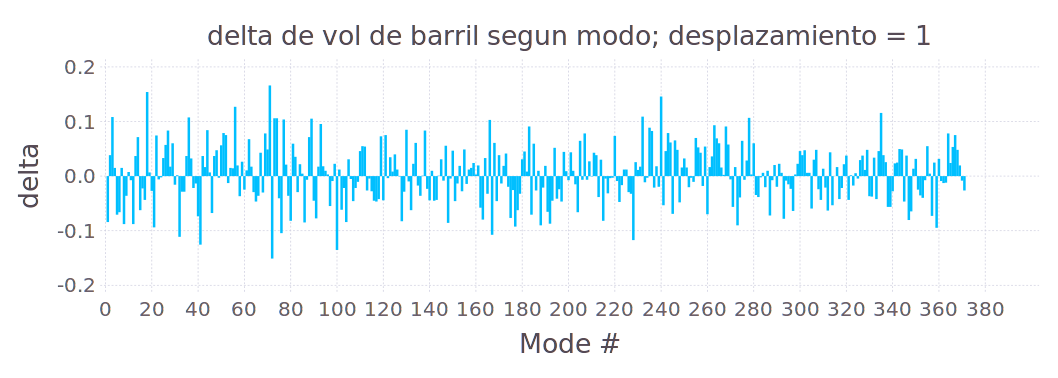

In [139]:
magnitude=1
out_vec_1 = string("/home/german/labo/16/lbp/cavities/mode_gradient/vtores/", magnitude,"_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1 = readtable(out_vec_1);
plot(df_vec_pocket_1,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de barril segun modo; desplazamiento = 1"),
Guide.xlabel("Mode #"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(0:20:380), orientation=:horizontal),
Theme(minor_label_font_size = 15pt, major_label_font_size = 20pt, key_title_font_size = 30pt))

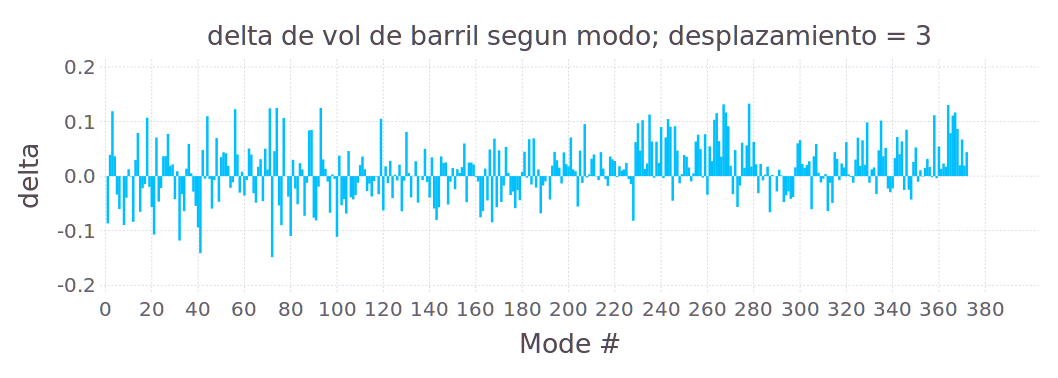

In [138]:
magnitude = 3
out_vec_1 = string("/home/german/labo/16/lbp/cavities/mode_gradient/vtores/", magnitude,"_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1 = readtable(out_vec_1);
plot(df_vec_pocket_1,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de barril segun modo; desplazamiento = 3"),
Guide.xlabel("Mode #"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(0:20:380), orientation=:horizontal),
Theme(minor_label_font_size = 15pt, major_label_font_size = 20pt, key_title_font_size = 30pt))

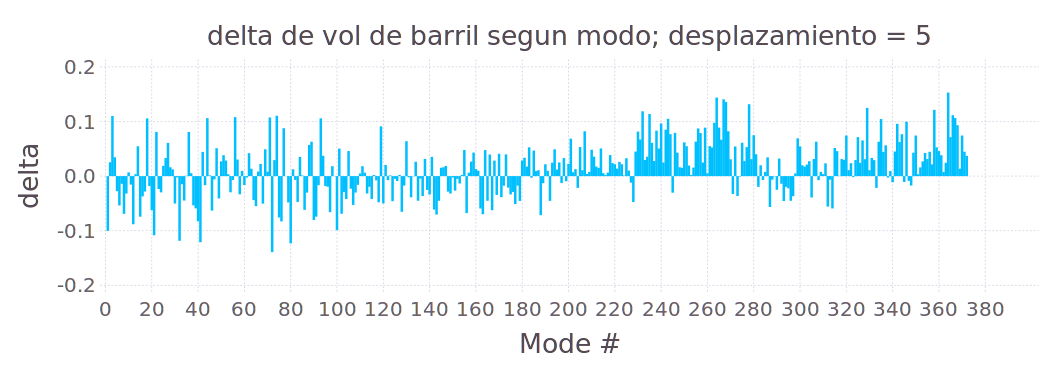

In [137]:
magnitude = 5
out_vec_1 = string("/home/german/labo/16/lbp/cavities/mode_gradient/vtores/", magnitude,"_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1 = readtable(out_vec_1);
plot(df_vec_pocket_1,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de barril segun modo; desplazamiento = 5"),
Guide.xlabel("Mode #"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(0:20:380), orientation=:horizontal),
Theme(minor_label_font_size = 15pt, major_label_font_size = 20pt, key_title_font_size = 30pt))

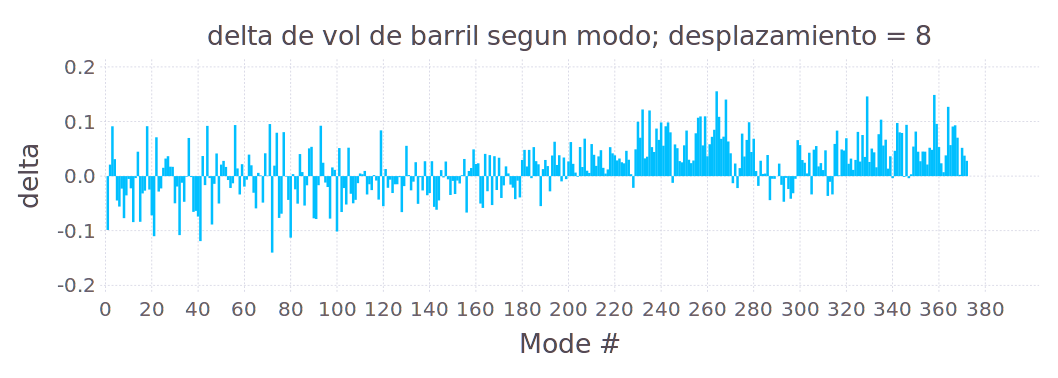

In [136]:
magnitude = 8
out_vec_1 = string("/home/german/labo/16/lbp/cavities/mode_gradient/vtores/", magnitude,"_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1 = readtable(out_vec_1);
plot(df_vec_pocket_1,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de barril segun modo; desplazamiento = 8"),
Guide.xlabel("Mode #"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(0:20:380), orientation=:horizontal),
Theme(minor_label_font_size = 15pt, major_label_font_size = 20pt, key_title_font_size = 30pt))

## Along cartesian coordinates

In [75]:
# Files de IN / OUT
# IN
pdb_name = "lfa_apo"
pdb_file_original = "/home/german/labo/16/lbp/cavities/cart_gradient/lfa_apo/lfa_apo.pdb"
files_template = "/home/german/labo/16/lbp/cavities/cart_gradient/lfa_apo/"
modos = "/home/german/labo/16/lbp/run/lfa_apo/pca/modes_lfa_apo"
conf_file = string("/home/german/labo/16/lbp/cavities/cart_gradient/lfa_apo/conf_", pdb_name, ".cfg")
pdb_name = "lfa_apo"
#OUT
vol_file = string("/home/german/labo/16/lbp/cavities/cart_gradient/lfa_apo/", "vol_", pdb_name)

# Leo el pdb
pdb = read(pdb_file_original, PDBFile, group="ATOM");
atom_xyz = coordinatesmatrix(pdb)
# Obtengo el número de átomos de c/ residuo
natom_res = Array{Int64}(1);
for i=1:length(pdb)
    push!(natom_res, length(pdb[i]))
end
shift!(natom_res)

# Preparo más variables
aa = length(pdb)
aa3 = length(pdb) * 3
#aa_index = collect(3:129)
aa_index = collect(1:aa)
aa3_index = map(x -> x*3, repeat(aa_index, inner=[3])) - repeat([2, 1, 0], outer = [length(aa_index)]);
# Arrays p/ guardar volumenes de pockets
vol_pocket_1 = Array{Float64}(aa3);

In [46]:
# Hago los .pdbs desplazados
constant = 0.01
for magnitude in [1 3 5 8]
    displacement = string("d", magnitude)    
    for j=1:aa
# Preparo p/ desplazar la estructura
        new_atom_xyz = copy(atom_xyz)
        new_pdb = copy(pdb)
        x_add = [repeat([1], inner=[natom_res[j]]) repeat([0], inner=[natom_res[j]]) repeat([0], inner=[natom_res[j]])]
        y_add = [repeat([0], inner=[natom_res[j]]) repeat([1], inner=[natom_res[j]]) repeat([0], inner=[natom_res[j]])]
        z_add = [repeat([0], inner=[natom_res[j]]) repeat([0], inner=[natom_res[j]]) repeat([1], inner=[natom_res[j]])]

# Desplazo en X
        displaced_atom_xyz = coordinatesmatrix(pdb[j]) + x_add .* magnitude .* constant
        new_pdb[j] = change_coordinates(pdb[j], displaced_atom_xyz)        
# Escribo el nuevo .pdb
        pdb_file = string(files_template, displacement, "/", "x", j, "_", displacement, "_", pdb_name,".pdb")
        write(pdb_file, new_pdb, PDBFile)
############
# Desplazo en Y
        displaced_atom_xyz = coordinatesmatrix(pdb[j]) + y_add .* magnitude .* constant
        new_pdb[j] = change_coordinates(pdb[j], displaced_atom_xyz)        
# Escribo el nuevo .pdb
        pdb_file = string(files_template, displacement, "/", "y", j, "_", displacement, "_", pdb_name,".pdb")
        write(pdb_file, new_pdb, PDBFile)
############
# Desplazo en Z
        displaced_atom_xyz = coordinatesmatrix(pdb[j]) + z_add .* magnitude .* constant
        new_pdb[j] = change_coordinates(pdb[j], displaced_atom_xyz)        
# Escribo el nuevo .pdb
        pdb_file = string(files_template, displacement, "/", "z", j, "_", displacement, "_", pdb_name,".pdb")
        write(pdb_file, new_pdb, PDBFile)
    end
end

In [89]:
# Calculo los vectores
magnitude = 5
displacement = string("d", magnitude)    
for j=1:aa    
    pdb_file = string(files_template, displacement, "/", "x", j, "_", displacement, "_", pdb_name,".pdb")
# Calculo los pockets
    run(`epock -s $pdb_file -c $conf_file -o $vol_file`)
    rtdo = readdlm(vol_file)
    vol_pocket_1[j*3-2] = rtdo[2, 2]
#    vol_pocket_2[j*3-2] = rtdo[2, 3]
#    vol_pocket_3[j*3-2] = rtdo[2, 4]
############
    pdb_file = string(files_template, displacement, "/", "y", j, "_", displacement, "_", pdb_name,".pdb")
# Calculo los pockets
    run(`epock -s $pdb_file -c $conf_file -o $vol_file`)
    rtdo = readdlm(vol_file)
    vol_pocket_1[j*3-1] = rtdo[2, 2]
#    vol_pocket_2[j*3-1] = rtdo[2, 3]
#    vol_pocket_3[j*3-1] = rtdo[2, 4]
############
    pdb_file = string(files_template, displacement, "/", "z", j, "_", displacement, "_", pdb_name,".pdb")
# Calculo los pockets
    run(`epock -s $pdb_file -c $conf_file -o $vol_file`)
    rtdo = readdlm(vol_file)
    vol_pocket_1[j*3] = rtdo[2, 2]
#    vol_pocket_2[j*3] = rtdo[2, 3]
#    vol_pocket_3[j*3] = rtdo[2, 4]    
end

# Calculo el pocket original
run(`epock -s $pdb_file_original -c $conf_file -o $vol_file`)
rtdo = readdlm(vol_file)
orig_vol_pocket_1 = rtdo[2, 2]
#orig_vol_pocket_2 = rtdo[2, 3]
#orig_vol_pocket_3 = rtdo[2, 4]

# Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
vec_pocket_1 = (vol_pocket_1 .- orig_vol_pocket_1)
#vec_pocket_2 = (vol_pocket_2 .- orig_vol_pocket_2).^2
#vec_pocket_3 = (vol_pocket_3 .- orig_vol_pocket_3).^2;
# Los normalizo
vec_pocket_1 = vec_pocket_1 / norm(vec_pocket_1)
#vec_pocket_2 = vec_pocket_2 / norm(vec_pocket_2)
#vec_pocket_3 = vec_pocket_3 / norm(vec_pocket_3)

# Los guardo
out_vec_1 = string("/home/german/labo/16/lbp/cavities/cart_gradient/vtores/00", magnitude,"_vec_pocket_lfa_apo_barrel")
#out_vec_2 = string("/home/german/labo/16/lbp/cavities/cart_gradient/lfa_apo/vtores/", magnitude,"_vec_pocket_mto_portal")
#out_vec_3 = string("/home/german/labo/16/lbp/cavities/cart_gradient/lfa_apo/vtores/", magnitude,"_vec_pocket_mto_largo")
df_vec_pocket_1 = DataFrame(delta = vec_pocket_1)
#df_vec_pocket_2 = DataFrame(delta = vec_pocket_2)
#df_vec_pocket_3 = DataFrame(delta = vec_pocket_3)
writetable(out_vec_1, df_vec_pocket_1)
#writetable(out_vec_2, df_vec_pocket_2)
#writetable(out_vec_3, df_vec_pocket_3);

# Ahora quiero saber q aa's afectaron al cambio de volumen del hueco.
wall_resi_pocket_1 = convert(Array{Int64}, unique(ceil(aa3_index[vec_pocket_1 .!= 0] ./ 3)))
#wall_resi_pocket_2 = convert(Array{Int64}, unique(ceil(aa3_index[vec_pocket_2 .!= 0] ./ 3)))
#wall_resi_pocket_3 = convert(Array{Int64}, unique(ceil(aa3_index[vec_pocket_3 .!= 0] ./ 3)));

## Comparo los vectores obtenidos

In [110]:
# Leo los 4 vectores obtenidos con distintos desplazamientos
out_vec_1 = string("/home/german/labo/16/lbp/cavities/cart_gradient/vtores/", "001","_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1_1 = readtable(out_vec_1);
out_vec_1 = string("/home/german/labo/16/lbp/cavities/cart_gradient/vtores/", "003","_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1_3 = readtable(out_vec_1);
out_vec_1 = string("/home/german/labo/16/lbp/cavities/cart_gradient/vtores/", "005","_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1_5 = readtable(out_vec_1);
out_vec_1 = string("/home/german/labo/16/lbp/cavities/cart_gradient/vtores/", "008","_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1_8 = readtable(out_vec_1);

# Hago productos escalares entre todos
mat = [ df_vec_pocket_1_1[:, 1] df_vec_pocket_1_3[:, 1] df_vec_pocket_1_5[:, 1] df_vec_pocket_1_8[:, 1] ]
transpose(mat) * mat

4x4 DataArrays.DataArray{Float64,2}:
 1.0       0.60314   0.546833  0.531959
 0.60314   1.0       0.869169  0.790644
 0.546833  0.869169  1.0       0.917783
 0.531959  0.790644  0.917783  1.0     

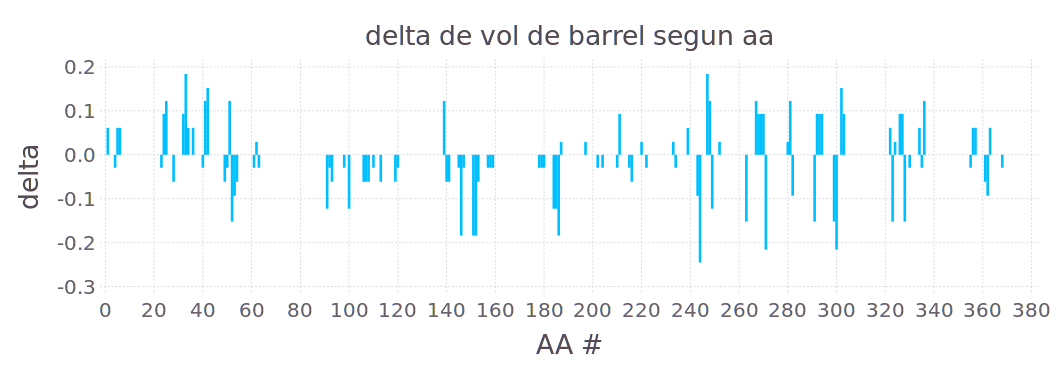

In [143]:
magnitude=1
out_vec_1 = string("/home/german/labo/16/lbp/cavities/cart_gradient/vtores/00", magnitude,"_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1 = readtable(out_vec_1);
plot(df_vec_pocket_1,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de barrel segun aa"),
Guide.xlabel("AA #"),
Coord.Cartesian(xmin=1, xmax=380),
Guide.xticks(ticks = collect(0:20:380), orientation=:horizontal),
Theme(minor_label_font_size = 15pt, major_label_font_size = 20pt, key_title_font_size = 30pt))

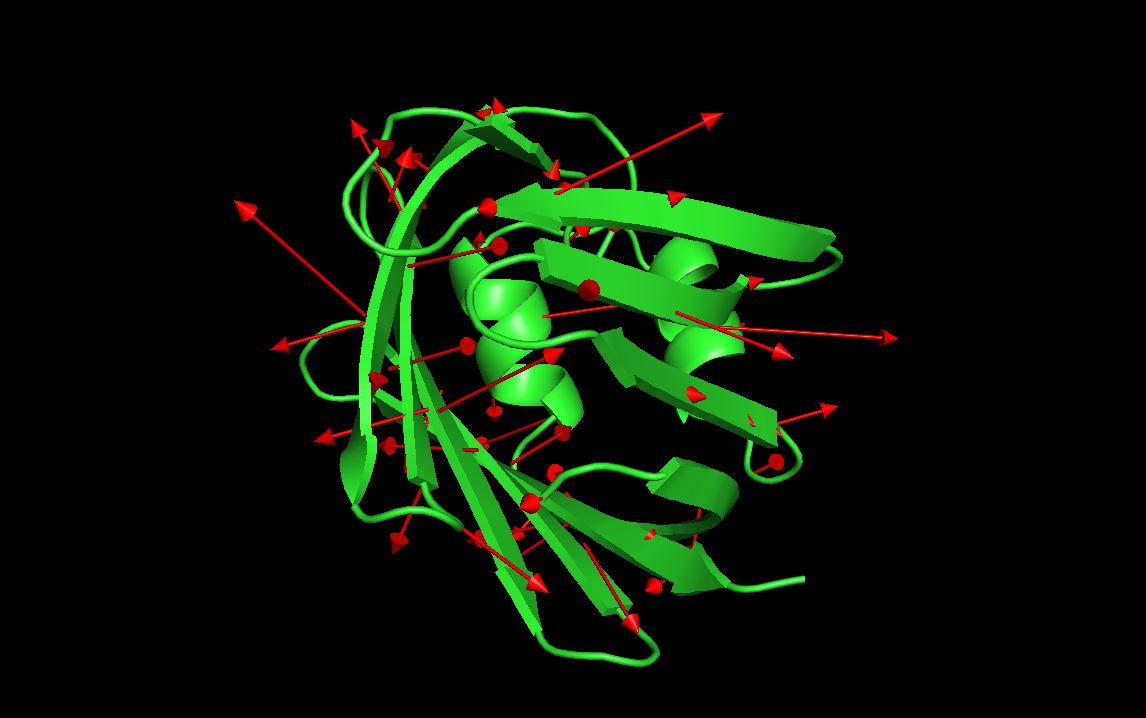

In [92]:
imread("/home/german/labo/16/lbp/cavities/cart_gradient/vtores/porcupine_lfa_apo_001.png.png")

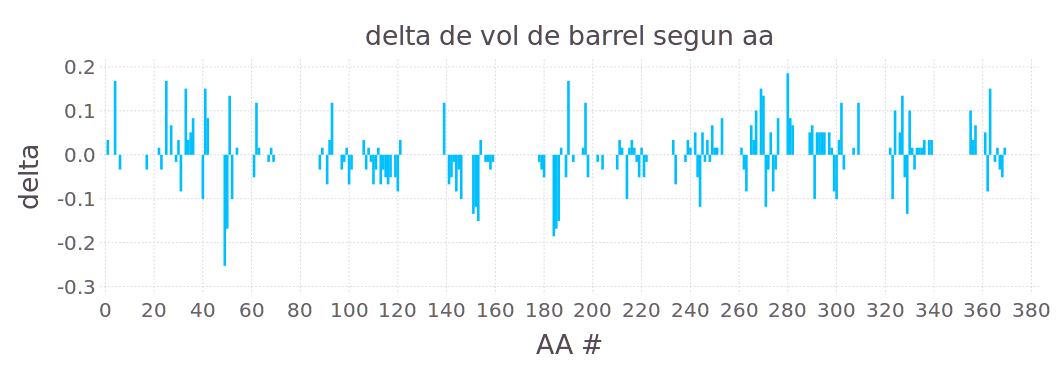

In [144]:
magnitude=3
out_vec_1 = string("/home/german/labo/16/lbp/cavities/cart_gradient/vtores/00", magnitude,"_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1 = readtable(out_vec_1);
plot(df_vec_pocket_1,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de barrel segun aa"),
Guide.xlabel("AA #"),
Coord.Cartesian(xmin=1, xmax=380),
Guide.xticks(ticks = collect(0:20:380), orientation=:horizontal),
Theme(minor_label_font_size = 15pt, major_label_font_size = 20pt, key_title_font_size = 30pt))

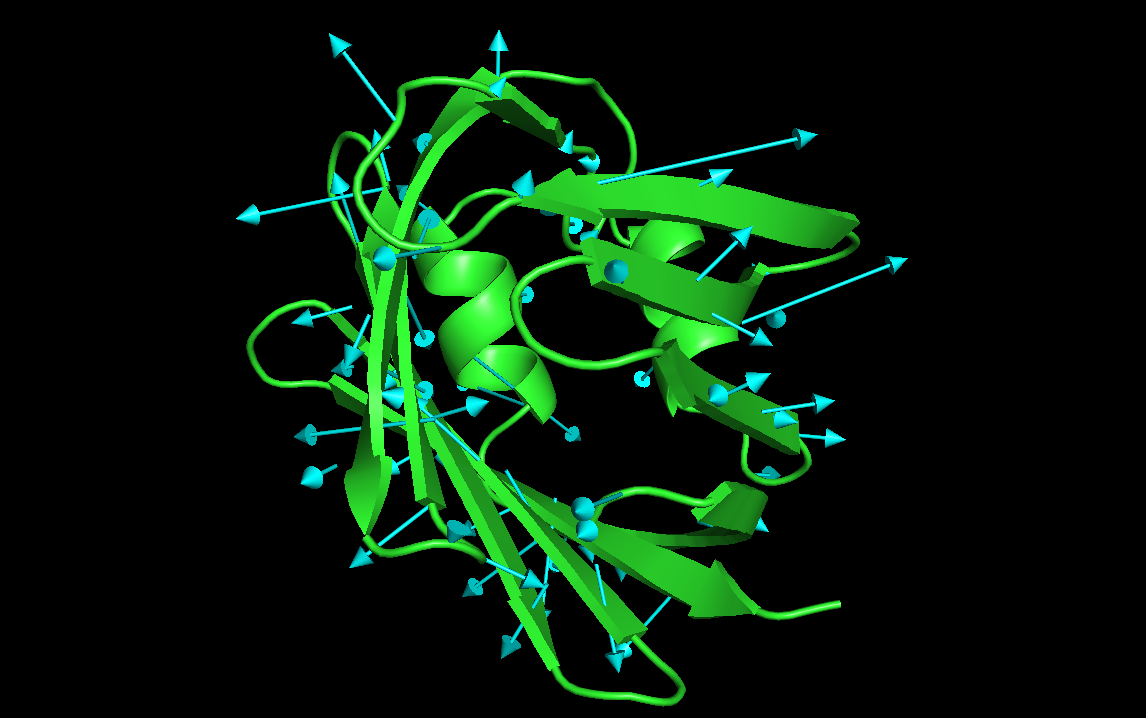

In [94]:
imread("/home/german/labo/16/lbp/cavities/cart_gradient/vtores/porcupine_lfa_apo_003.png")

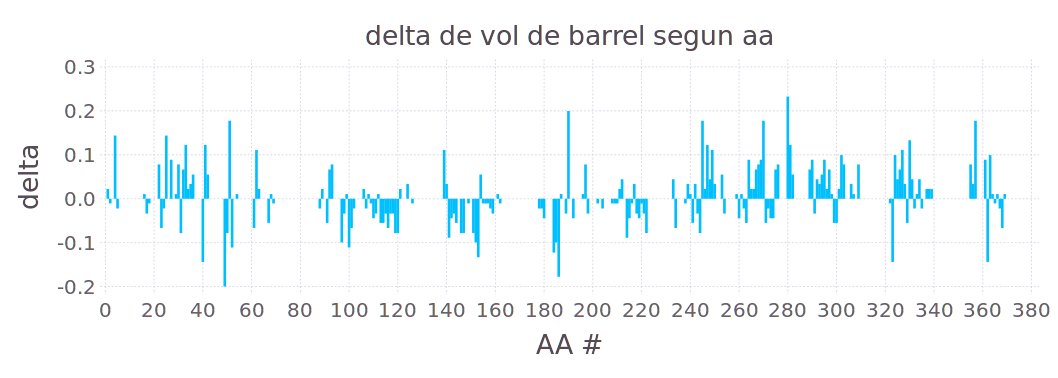

In [145]:
magnitude = 5
out_vec_1 = string("/home/german/labo/16/lbp/cavities/cart_gradient/vtores/00", magnitude,"_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1 = readtable(out_vec_1);
plot(df_vec_pocket_1,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de barrel segun aa"),
Guide.xlabel("AA #"),
Coord.Cartesian(xmin=1, xmax=380),
Guide.xticks(ticks = collect(0:20:380), orientation=:horizontal),
Theme(minor_label_font_size = 15pt, major_label_font_size = 20pt, key_title_font_size = 30pt))

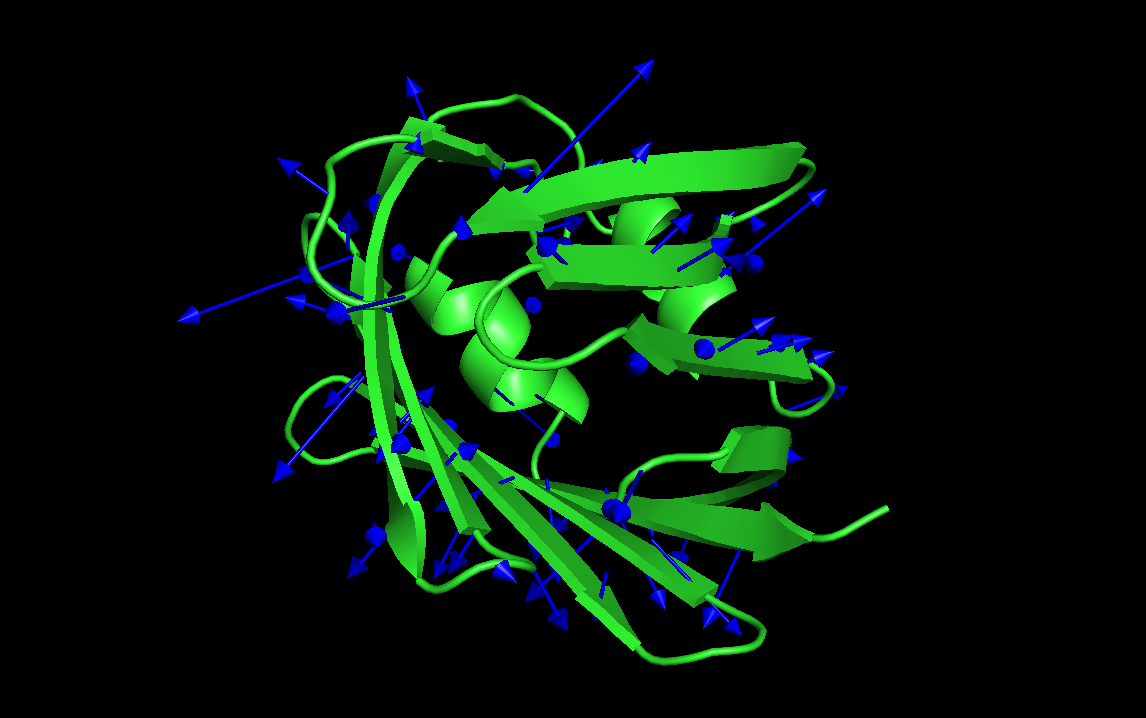

In [96]:
imread("/home/german/labo/16/lbp/cavities/cart_gradient/vtores/porcupine_lfa_apo_005.png")

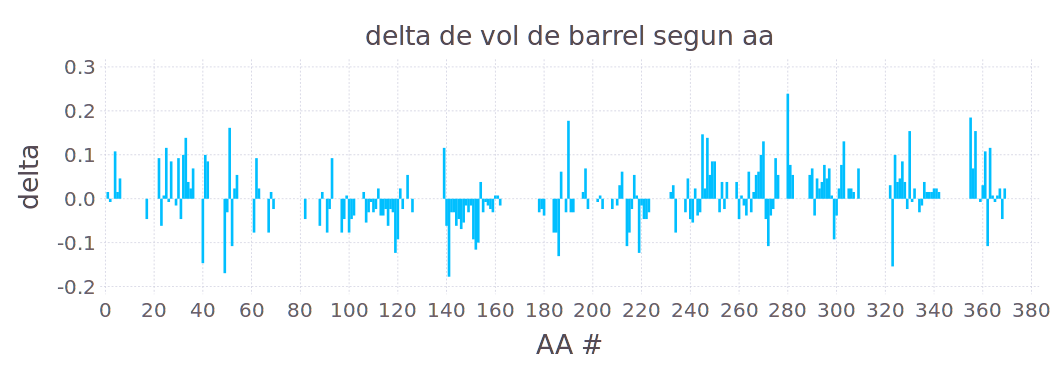

In [146]:
magnitude=8
out_vec_1 = string("/home/german/labo/16/lbp/cavities/cart_gradient/vtores/00", magnitude,"_vec_pocket_lfa_apo_barrel")
df_vec_pocket_1 = readtable(out_vec_1);
plot(df_vec_pocket_1,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de barrel segun aa"),
Guide.xlabel("AA #"),
Coord.Cartesian(xmin=1, xmax=380),
Guide.xticks(ticks = collect(0:20:380), orientation=:horizontal),
Theme(minor_label_font_size = 15pt, major_label_font_size = 20pt, key_title_font_size = 30pt))

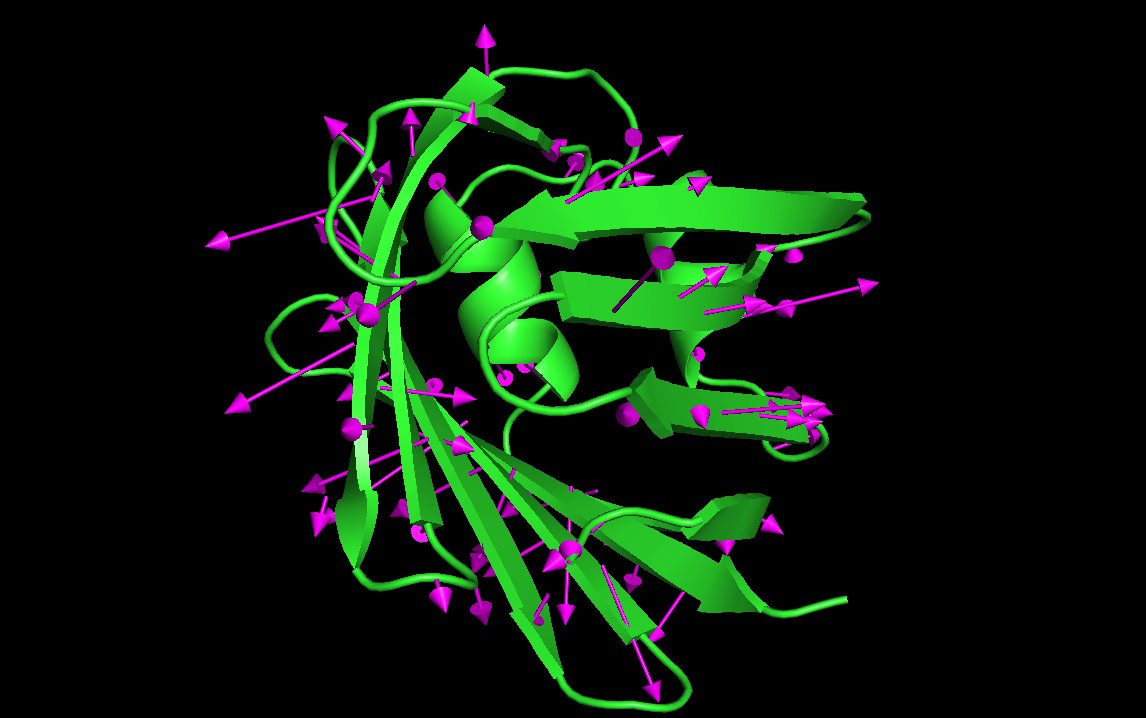

In [98]:
imread("/home/german/labo/16/lbp/cavities/cart_gradient/vtores/porcupine_lfa_apo_008.png")

##  Obtengo una estructura desplazada en el sentido del gradiente p/ hacer el porcupine plot

In [90]:
# Muevo a lo largo de un vector de gradiente en coordenadas XYZ
temp1_modo_sum = Array{Float64}(natom_res[1], 3)
for i=1:aa
    modo_sum[i, 1] = vec_pocket_1[i*3-2]
    modo_sum[i, 2] = vec_pocket_1[i*3-1]
    modo_sum[i, 3] = vec_pocket_1[i*3]
end
# Ya tengo el vector en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q 
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1            
                temp1_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
                continue
            end
            temp2_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)
        end
modo_sum = copy(temp1_modo_sum)
# Ajusto el desplazamiento q voy a hacer
factor = 40
# Modifico las coordenadas                
mto_atom_xyz = copy(atom_xyz)
new_mto_atom_xyz = mto_atom_xyz + modo_sum .* factor;
# Obtengo un nuevo frame con las coordenadas modificadas
new_pdb = change_coordinates(pdb, new_mto_atom_xyz)
# Escribo el nuevo .pdb
new_pdb_file = string("/home/german/labo/16/lbp/cavities/cart_gradient/vtores/lfa_apo_barrel_00", magnitude, ".pdb")
write(new_pdb_file, new_pdb, PDBFile)